In [11]:
# data science
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import seaborn as sns
import datetime

# API
import requests
import json

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func

import geojson

In [2]:
df = pd.read_csv('AQI_clean.csv')
df.head()

,country,city,aqi_value,aqi_category,co_aqi_value,co_aqi_category,ozone_aqi_value,ozone_aqi_category,no2_aqi_value,no2_aqi_category,pm2_5_aqi_value,pm2_5_aqi_category,latitude,longitude
0,Russian Federation,Praskoveya,51,Moderate,1,Good,36,Good,0,Good,51,Moderate,44.7444,44.2031
1,Brazil,Presidente Dutra,41,Good,1,Good,5,Good,1,Good,41,Good,-5.2900,-44.4900
2,Brazil,Presidente Dutra,41,Good,1,Good,5,Good,1,Good,41,Good,-11.2958,-41.9869
3,Italy,Priolo Gargallo,66,Moderate,1,Good,39,Good,2,Good,66,Moderate,37.1667,15.1833
4,Poland,Przasnysz,34,Good,1,Good,34,Good,0,Good,20,Good,53.0167,20.8833


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16393 entries, 0 to 16392
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             16393 non-null  object 
 1   city                16393 non-null  object 
 2   aqi_value           16393 non-null  int64  
 3   aqi_category        16393 non-null  object 
 4   co_aqi_value        16393 non-null  int64  
 5   co_aqi_category     16393 non-null  object 
 6   ozone_aqi_value     16393 non-null  int64  
 7   ozone_aqi_category  16393 non-null  object 
 8   no2_aqi_value       16393 non-null  int64  
 9   no2_aqi_category    16393 non-null  object 
 10  pm2_5_aqi_value     16393 non-null  int64  
 11  pm2_5_aqi_category  16393 non-null  object 
 12  latitude            16393 non-null  float64
 13  longitude           16393 non-null  float64
dtypes: float64(2), int64(5), object(7)
memory usage: 1.8+ MB


In [4]:
engine = create_engine("sqlite:///aqi.sqlite")

In [5]:
# query = """CREATE TABLE "aqi" (
#	"id" integer Primary key,
#	"country" varchar(100),
#	"city" varchar(100),
#	"aqi_value" integer,
#	"aqi_category" varchar(30),
#	"co_aqi_value" integer,
#	"co_aqi_category" varchar(30),
#	"ozone_aqi_value" integer,
#	"ozone_aqi_category" varchar(30),
#	"no2_aqi_value" integer,
#	"no2_aqi_category" varchar(30),
#	"pm2_5_aqi_value" integer,
#	"pm2_5_aqi_category" varchar(30),
#	"latitude" float,
#	"longitude" float
# );"""

# with engine.connect() as conn:
#    conn.execute(text(query))

In [6]:
# df.to_sql("aqi", con=engine, index=False, method="multi", if_exists="append")

In [7]:
 # INSPECT to confirm existence

# Create the inspector and connect it to the engine
inspector_gadget = inspect(engine)

# Collect the names of tables within the database
tables = inspector_gadget.get_table_names()

# print metadata for each table
for table in tables:
    print(table)
    print("-----------")
    
    # get columns
    columns = inspector_gadget.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print() 

aqi
-----------
id INTEGER
country VARCHAR(100)
city VARCHAR(100)
aqi_value INTEGER
aqi_category VARCHAR(30)
co_aqi_value INTEGER
co_aqi_category VARCHAR(30)
ozone_aqi_value INTEGER
ozone_aqi_category VARCHAR(30)
no2_aqi_value INTEGER
no2_aqi_category VARCHAR(30)
pm2_5_aqi_value INTEGER
pm2_5_aqi_category VARCHAR(30)
latitude FLOAT
longitude FLOAT



In [8]:
 # Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

# Print all of the classes mapped to the Base

print(list(Base.classes))

[<class 'sqlalchemy.ext.automap.aqi'>]


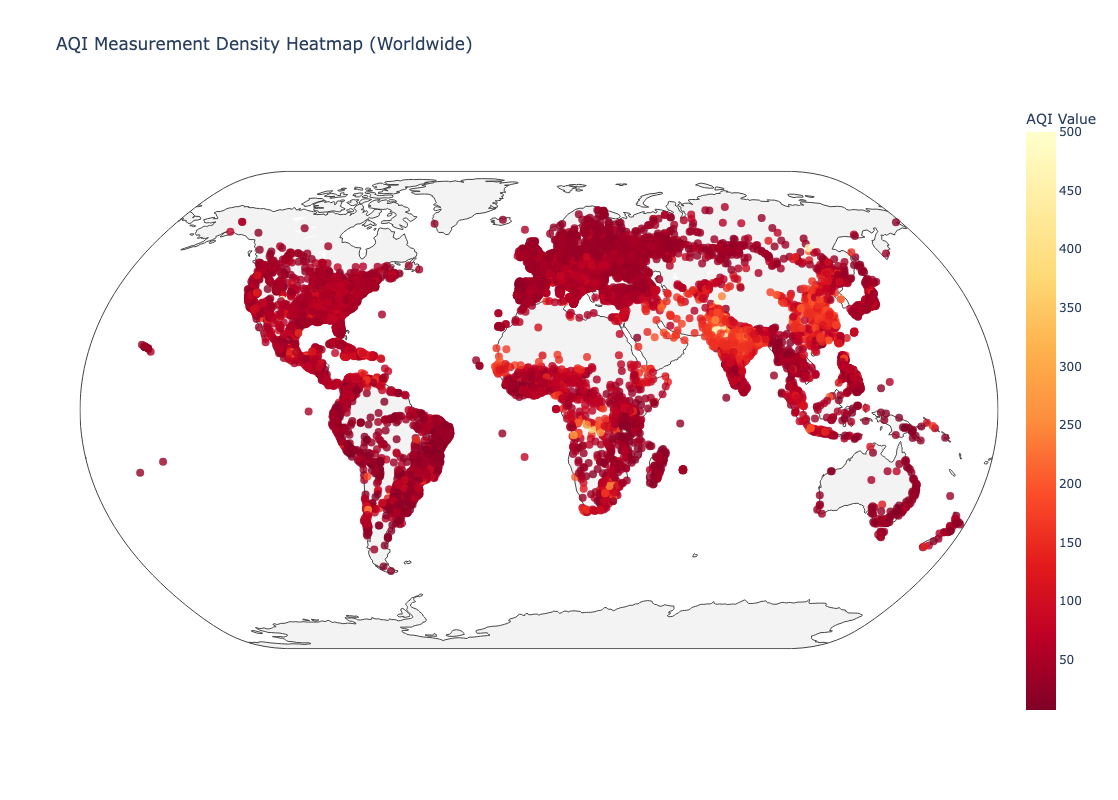

In [13]:
# USER-SELECTED COUNTRY OR 'All'
user_input = "All"  # Change this value as needed

# Query to filter data based on user input
query = f"""
    SELECT latitude, longitude, aqi_value 
    FROM aqi
    WHERE {'country = :country' if user_input != 'All' else '1=1'}
"""

# Fetch data from the database
params = {"country": user_input} if user_input != "All" else {}
df_heatmap = pd.read_sql(query, engine, params=params)

# Create Plotly figure
fig = go.Figure(data=go.Scattergeo(
    lon=df_heatmap['longitude'],
    lat=df_heatmap['latitude'],
    mode='markers',
    marker=dict(
        size=8,
        opacity=0.8,
        reversescale=True,
        autocolorscale=False,
        colorscale='YlOrRd', # Yellow to Red color scale
        color=df_heatmap['aqi_value'], # Use AQI values for color intensity
        cmin=df_heatmap['aqi_value'].min(),
        cmax=df_heatmap['aqi_value'].max(),
        colorbar=dict(title="AQI Value") # Add colorbar
    )
))

# Customize layout (world map, title, etc.)
fig.update_layout(
    title='AQI Measurement Density Heatmap (Worldwide)',
    geo=dict(
        scope='world',
        projection_type='natural earth',
        showland=True,
        landcolor='rgb(243, 243, 243)',
        countrycolor='rgb(204, 204, 204)'
    ),
    width=1200,  # Set the width of the figure in pixels
    height=800   # Set the height of the figure in pixels
)

fig.show()